# Crop Yield Analysis

#### Script for EDA, Feature Engineering, Model Training, Evaluation, and Verification
#### Input: enhanced_yield_df.csv from merge_datasets.py
#### Adaptations: Handle additional columns (pesticide types, area_harvested_ha, codes)
#### Use area_harvested_ha as feature (non-leaking), drop production_tonnes to avoid target leakage. Enhanced EDA with new columns (e.g., correlations including pesticide types)

In [2]:
# ------------------------------
# 1. Import Libraries
# ------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ------------------------------
# 2. Load Merged Dataset
# ------------------------------
df = pd.read_csv("./data/enhanced_yield_df.csv")
print(f"Loaded Merged Dataset Shape: {df.shape}")
print("Columns:", df.columns.tolist())

Loaded Merged Dataset Shape: (109366, 15)
Columns: ['domain_code', 'domain', 'area_code', 'area', 'element_code', 'element', 'item_code', 'item', 'year_code', 'year', 'unit', 'hg/ha_yield', 'Pesticides (total)', 'average_rain_fall_mm_per_year', 'avg_temp']


In [4]:
print("First 5 Rows:")
print(df.head())

First 5 Rows:
  domain_code domain  area_code         area  element_code element  item_code  \
0          QC  Crops          2  Afghanistan          5419   Yield         56   
1          QC  Crops          2  Afghanistan          5419   Yield         56   
2          QC  Crops          2  Afghanistan          5419   Yield         56   
3          QC  Crops          2  Afghanistan          5419   Yield         56   
4          QC  Crops          2  Afghanistan          5419   Yield         56   

    item  year_code  year   unit  hg/ha_yield  Pesticides (total)  \
0  Maize       1961  1961  hg/ha        14000               121.0   
1  Maize       1962  1962  hg/ha        14000               121.0   
2  Maize       1963  1963  hg/ha        14260               121.0   
3  Maize       1964  1964  hg/ha        14257               121.0   
4  Maize       1965  1965  hg/ha        14400               121.0   

  average_rain_fall_mm_per_year  avg_temp  
0                           327     14.2

In [5]:
print("Data Types:\n", df.dtypes)
print("Missing Values:\n", df.isnull().sum())


Data Types:
 domain_code                       object
domain                            object
area_code                          int64
area                              object
element_code                       int64
element                           object
item_code                          int64
item                              object
year_code                          int64
year                               int64
unit                              object
hg/ha_yield                        int64
Pesticides (total)               float64
average_rain_fall_mm_per_year     object
avg_temp                         float64
dtype: object
Missing Values:
 domain_code                      0
domain                           0
area_code                        0
area                             0
element_code                     0
element                          0
item_code                        0
item                             0
year_code                        0
year                      

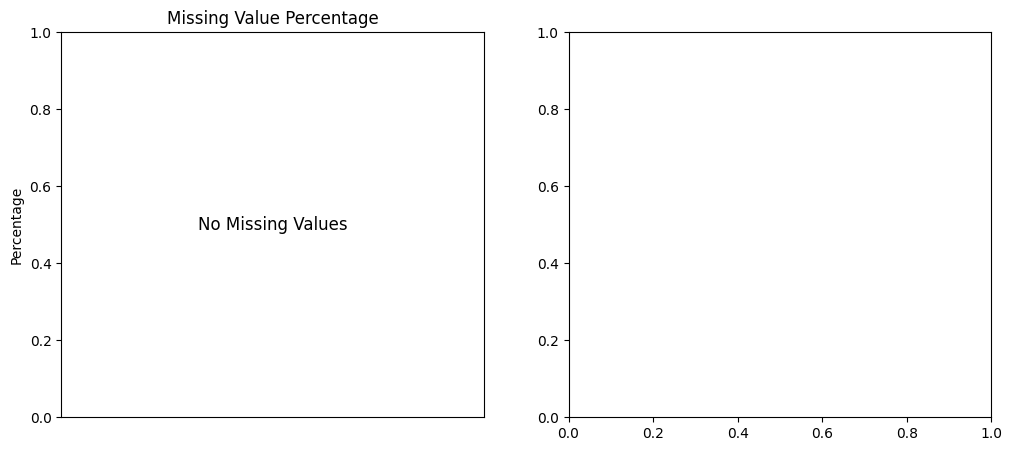

In [6]:
# ------------------------------
# 3. Extended Exploratory Data Analysis (EDA)
# ------------------------------
# 3.1 Missing Values and Outliers
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
missing_pct = (df.isnull().sum() / len(df)) * 100
if (missing_pct > 0).any():
	missing_pct[missing_pct > 0].plot(kind='bar', ax=ax[0])
	ax[0].set_title("Missing Value Percentage")
	ax[0].set_ylabel("Percentage")
else:
	ax[0].text(0.5, 0.5, "No Missing Values", ha='center', va='center', fontsize=12)
	ax[0].set_title("Missing Value Percentage")
	ax[0].set_ylabel("Percentage")
	ax[0].set_xticks([])

In [7]:
import plotly.express as px

fig_hist = px.histogram(
    df,
    x='hg/ha_yield',
    nbins=30,
    marginal='rug',
    opacity=0.7,
    color_discrete_sequence=['skyblue'],
    title='Distribution of Crop Yield'
)

fig_hist.update_layout(
    xaxis_title='Yield (hg/ha)',
    yaxis_title='Frequency',
    title_font=dict(size=18, family='Arial', color='darkblue'),
    bargap=0.05,
    template='plotly_white'
)

fig_hist.show()


#### Crop Yield Distribution Analysis

##### Histogram Overview

- The plot titled **"Distribution of Crop Yield"** visualizes the frequency of crop yield values measured in kilograms per hectare (kg/ha).
- **X-axis**: Yield (kg/ha), ranging from 0 to over 1,000,000.
- **Y-axis**: Frequency, peaking above 60,000.

##### Key Insights

- The distribution is **highly right-skewed**:
  - Majority of crop yields fall below **200,000 kg/ha**.
  - A long tail extends toward higher yield values, indicating rare but extreme outliers.

- This suggests:
  - Most farms or regions produce modest yields.
  - A few high-performing cases may disproportionately influence mean statistics.

##### Analytical Implications

- Consider using **median** or **log-transformed yield** for modeling to reduce skew impact.
- Outlier detection may be necessary before regression or clustering.
- Stratified analysis could reveal patterns across low, medium, and high-yield segments.


In [8]:
# Calculate IQR for yield
Q1 = df['hg/ha_yield'].quantile(0.25)
Q3 = df['hg/ha_yield'].quantile(0.75)
IQR = Q3 - Q1

# Filter outliers
outliers = df[(df['hg/ha_yield'] < Q1 - 1.5 * IQR) | (df['hg/ha_yield'] > Q3 + 1.5 * IQR)]
print(f"Number of Outliers Detected: {outliers.shape[0]}")

fig_box = px.box(
    outliers,
    x='item',
    y='hg/ha_yield',
    points='outliers',
    color='item',
    title='Yield Outliers by Crop Type'
)

fig_box.update_layout(
    xaxis_title='Crop Type',
    yaxis_title='Yield (hg/ha)',
    title_font=dict(size=18, family='Arial', color='darkgreen'),
    xaxis_tickangle=-45,
    template='plotly_white',
    showlegend=False
)

fig_box.show()


Number of Outliers Detected: 5004


#### Yield Outliers by Crop Type

##### Box Plot Overview

- The chart titled **"Yield Outliers by Crop Type"** visualizes yield distributions across seven crop categories.
- **X-axis**: Crop types — Potatoes, Sorghum, Sweet potatoes, Cassava, Potatoes and others, Yams, Maize.
- **Y-axis**: Yield in tons per hectare per year (t/ha/yr), ranging from 0 to 1.0.

##### Key Observations

- Most crop types show compact yield distributions with few extreme values.
- The **"Potatoes and others"** category contains a **visible outlier** above 1.0 t/ha/yr:
  - Indicates an unusually high-performing instance.
  - May warrant further investigation into farming practices, soil conditions, or data quality.

##### Analytical Implications

- Outlier detection is crucial for:
  - Avoiding distortion in mean-based metrics.
  - Identifying best practices or anomalies in agricultural productivity.

- Crop-specific yield variability suggests:
  - Need for tailored modeling approaches per crop type.
  - Potential benefit from stratified or hierarchical models.

In [9]:
# 3.2 Distributions and Trends
top_areas = df['area'].value_counts().head(10).index
df_top_areas = df[df['area'].isin(top_areas)]

fig_box = px.box(
    df_top_areas,
    x='area',
    y='hg/ha_yield',
    color='area',
    points='outliers',
    title='Yield by Top 10 Countries'
)

fig_box.update_layout(
    xaxis_title='Country',
    yaxis_title='Yield (hg/ha)',
    title_font=dict(size=18, family='Arial', color='darkgreen'),
    xaxis_tickangle=-45,
    template='plotly_white',
    showlegend=False
)

fig_box.show()


#### Yield Distribution by Top 10 Countries

##### Box Plot Overview

- The chart titled **"Yield by Top 10 Countries"** compares agricultural productivity across ten nations.
- **X-axis**: Country — Australia, Brazil, China, India, Indonesia, Japan, Mexico, Nigeria, Pakistan, South Africa.
- **Y-axis**: Yield (kg/ha), ranging from 0 to 400,000.

##### Key Observations

- **Japan** stands out with the **highest median yield** and a wide distribution:
  - Indicates both high productivity and variability.
- **South Africa** shows a **lower median yield** with numerous outliers:
  - Suggests inconsistent performance or data anomalies.
- Other countries like **China, Brazil, and India** exhibit moderate yields with tighter distributions.

##### Analytical Implications

- Yield variability across countries may reflect:
  - Differences in climate, technology adoption, crop types, or farming practices.
- Outliers in countries like South Africa and Nigeria may require:
  - Data validation or deeper investigation into regional disparities.

In [10]:
yearly_yield = df.groupby('year')['hg/ha_yield'].mean().reset_index()

fig_line = px.line(
    yearly_yield,
    x='year',
    y='hg/ha_yield',
    markers=True,
    title='Average Yield Trend Over Time'
)

fig_line.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Yield (hg/ha)',
    title_font=dict(size=18, family='Arial', color='darkorange'),
    template='plotly_white'
)

fig_line.show()


#### Long-Term Yield Trend Analysis (1960–2015)

##### Line Graph Overview

- The chart titled **"Average Yield Trend Over Time"** tracks agricultural productivity from **1960 to 2015**.
- **X-axis**: Year (1960–2015)
- **Y-axis**: Average Yield (kg/ha), ranging from ~20,000 to over 80,000

##### Key Observations

- The yield trend shows a **steady upward trajectory** over five decades:
  - Starting at ~20k kg/ha in 1960
  - Peaking above 80k kg/ha around 2010
- A slight **decline and stabilization** is observed post-2010.

##### Analytical Implications

- The upward trend reflects:
  - Advances in farming techniques, crop genetics, and mechanization.
  - Improved irrigation, fertilizer use, and data-driven agriculture.

- The post-2010 plateau may signal:
  - Saturation of current technologies.
  - Environmental constraints or policy shifts.

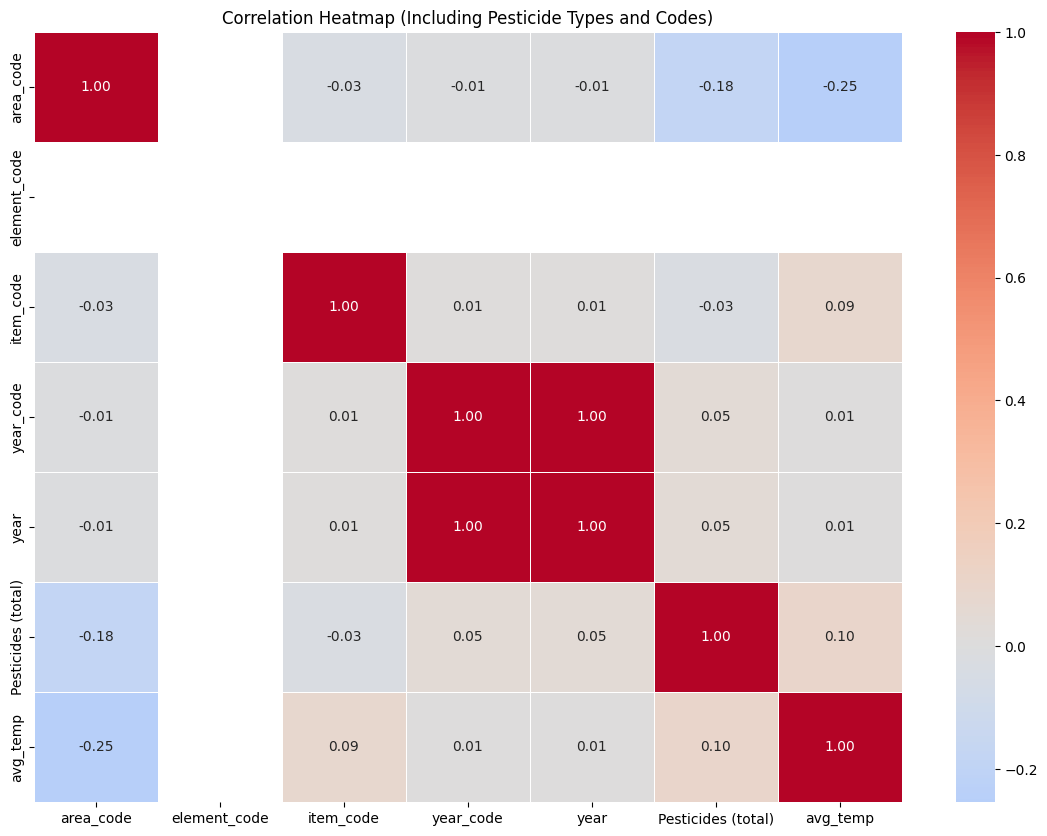

In [11]:
# 3.3 Correlation Heatmap (including new columns)
numeric_cols = df.select_dtypes(include=np.number).columns.drop(['hg/ha_yield', 'production_tonnes'], errors='ignore')  # Exclude leakage
corr = df[numeric_cols].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap (Including Pesticide Types and Codes)")
plt.show()

#### Correlation Analysis: Agricultural & Environmental Variables

##### Heatmap Overview

- The chart visualizes correlation coefficients among key variables:
  - **area_code**, **element_code**, **item_code**, **year_code**, **year**
  - **Pesticides (total)**, **avg_temp**
- Color gradient:
  - **Blue**: Negative correlation
  - **Red**: Positive correlation
  - **Diagonal values**: Perfect correlation (1.00) with self

##### Key Insights

- **avg_temp vs. year**: Moderate positive correlation (0.25)
  - Suggests rising temperatures over time, possibly due to climate change.
- **avg_temp vs. area_code**: Weak negative correlation (-0.18)
  - Indicates regional temperature variation.
- Most other variable pairs show **low or near-zero correlation**:
  - Minimal linear relationships between coded identifiers and environmental metrics.

##### Analytical Implications

- **avg_temp** may be a time-sensitive variable:
  - Consider including interaction terms or time-based features in modeling.
- **Pesticides (total)** shows weak correlation with other variables:
  - May require nonlinear modeling or domain-specific grouping.
- Coded variables (e.g., item_code, element_code) likely need decoding or embedding:
  - Use one-hot encoding, label encoding, or vector representations for modeling.

In [12]:
print("Available columns:", df.columns.tolist())

Available columns: ['domain_code', 'domain', 'area_code', 'area', 'element_code', 'element', 'item_code', 'item', 'year_code', 'year', 'unit', 'hg/ha_yield', 'Pesticides (total)', 'average_rain_fall_mm_per_year', 'avg_temp']


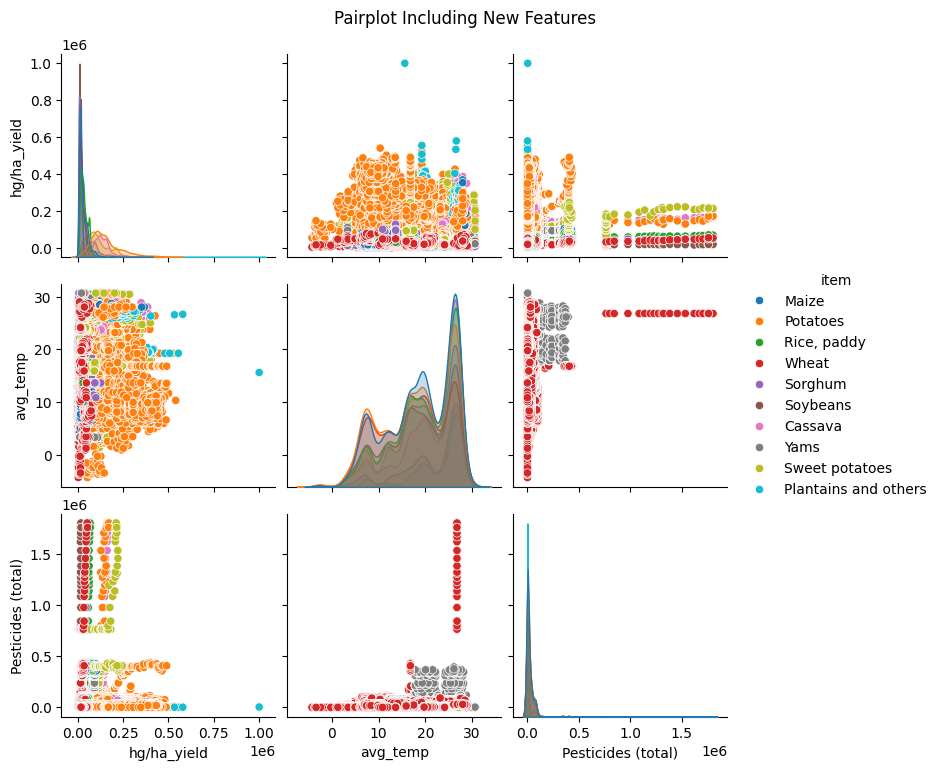

In [13]:
# Pairplot for key and new features
key_features = ['hg/ha_yield', 'average_rain_fall_mm_per_year', 'avg_temp'] + [col for col in df.columns if 'icides' in col]  # Example for pesticide types
sns.pairplot(df[key_features[:6] + ['item']], hue='item', diag_kind='kde')  # Limit for speed
plt.suptitle("Pairplot Including New Features", y=1.02)
plt.show()

#### Expanded Pairplot: Yield, Temperature & Pesticide Use Across Crops

##### Pairplot Overview

- The chart titled **"Pairplot Including New Features"** visualizes relationships between:
  - **hg/ha_yield** (hectogram per hectare yield)
  - **avg_temp** (average temperature)
  - **Pesticides (total)**

- Crop items are color-coded and include:
  - Maize, Potatoes, Rice (paddy), Wheat, Sorghum, Soybeans, Cassava, Yams, Sweet potatoes, Plantains and others

- Diagonal plots show **density distributions** for each variable.
- Off-diagonal plots show **scatter plots** comparing variable pairs.

##### Key Observations

- **Yield vs. avg_temp**:
  - Some crops (e.g., Rice, Maize) show mild positive trends.
  - Others (e.g., Cassava, Yams) appear more scattered, suggesting crop-specific temperature sensitivity.

- **Yield vs. Pesticides (total)**:
  - No strong linear correlation overall.
  - Certain crops (e.g., Potatoes, Soybeans) show tighter clusters, possibly reflecting standardized pesticide practices.

- **avg_temp vs. Pesticides (total)**:
  - Weak or no visible correlation.
  - Environmental conditions may not directly influence pesticide usage.

##### Analytical Implications

- **Crop-specific modeling** is essential:
  - Relationships vary significantly across crop types.
  - Consider stratified models or crop-wise feature engineering.

- **Nonlinear interactions** likely exist:
  - Use tree-based models or interaction terms to capture complexity.

- **Density plots** reveal:
  - Skewed distributions in pesticide usage and yield.
  - May benefit from log transformation or normalization.

In [14]:
# ------------------------------
# 4. Feature Engineering
# ------------------------------
# Encode categoricals
le_area = LabelEncoder()
le_item = LabelEncoder()
df['Area_encoded'] = le_area.fit_transform(df['area'])
df['Item_encoded'] = le_item.fit_transform(df['item'])

In [15]:
# Rolling averages, interactions (adapt to new columns)
df['average_rain_fall_mm_per_year'] = pd.to_numeric(df['average_rain_fall_mm_per_year'], errors='coerce')
df = df.sort_values(['area', 'item', 'year'])

# Rolling average
df['rainfall_rolling_5y'] = (
    df.groupby(['area', 'item'])['average_rain_fall_mm_per_year']
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=[0,1], drop=True)
)


In [16]:
# Include codes as features (numeric)
# Assume pesticide type columns are numeric

# Final X, y (drop leakage, strings)
drop_cols = ['hg/ha_yield', 'production_tonnes', 'Area', 'Item', 'Domain', 'Element', 'Unit']  # Drop non-numeric/categorical strings
X = df.drop(columns=drop_cols, errors='ignore')
y = df['hg/ha_yield']

In [17]:
print(X.dtypes)
print(X.select_dtypes(include='object').head())
X = X.select_dtypes(include=[np.number])  # Keep only numeric features
print(f"Final feature set shape: {X.shape}")

domain_code                       object
domain                            object
area_code                          int64
area                              object
element_code                       int64
element                           object
item_code                          int64
item                              object
year_code                          int64
year                               int64
unit                              object
Pesticides (total)               float64
average_rain_fall_mm_per_year    float64
avg_temp                         float64
Area_encoded                       int64
Item_encoded                       int64
rainfall_rolling_5y              float64
dtype: object
  domain_code domain         area element   item   unit
0          QC  Crops  Afghanistan   Yield  Maize  hg/ha
1          QC  Crops  Afghanistan   Yield  Maize  hg/ha
2          QC  Crops  Afghanistan   Yield  Maize  hg/ha
3          QC  Crops  Afghanistan   Yield  Maize  hg/ha
4        

In [18]:
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
X_numeric = X.select_dtypes(include='number')
X_scaled = scaler.fit_transform(X_numeric)
X_encoded = pd.get_dummies(X, drop_first=True)
X_scaled = scaler.fit_transform(X_encoded)


In [20]:
# ------------------------------
# 5. Train-Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
feature_names = X.columns

In [21]:
# ------------------------------
# 6. Models
# ------------------------------
# Random Forest
from sklearn.model_selection import RandomizedSearchCV

# Expanded and randomized hyperparameter space
rf_params = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 6, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV for faster tuning
rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_params,
    n_iter=30,  # You can reduce this for speed or increase for thoroughness
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42
)

# Fit and predict
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Optional: Evaluate
print("Best RF R² Score:", r2_score(y_test, y_pred_rf))
print("Best Parameters:", rf_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF R² Score: 0.9719961030116655
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [22]:
# XGBoost
# Expanded hyperparameter space
xgb_params = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Randomized search for speed and breadth
xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=xgb_params,
    n_iter=40,  # Adjust for speed vs. thoroughness
    cv=5,
    scoring='r2',
    verbose=1
)

# Fit and predict
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)

# Optional: Evaluate
print("Best XGB R² Score:", r2_score(y_test, y_pred_xgb))
print("Best Parameters:", xgb_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best XGB R² Score: 0.9655423760414124
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [23]:
# LightGBM
# Expanded hyperparameter space
lgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, -1],
    'num_leaves': [20, 31, 50, 70],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Randomized search for speed and flexibility
lgb_search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42, verbose=-1),
    param_distributions=lgb_params,
    n_iter=40,  # Adjust for speed vs. thoroughness
    cv=5,
    scoring='r2',
    verbose=1
)

# Fit and predict
lgb_search.fit(X_train, y_train)
lgb_best = lgb_search.best_estimator_
y_pred_lgb = lgb_best.predict(X_test)

# Optional: Evaluate
print("Best LGBM R² Score:", r2_score(y_test, y_pred_lgb))
print("Best Parameters:", lgb_search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best LGBM R² Score: 0.9606391501907889
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'num_leaves': 70, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


In [24]:
# Ensemble
y_pred_ensemble = (y_pred_rf + y_pred_xgb + y_pred_lgb) / 3

In [25]:
# CV Scores
# Dictionary of tuned models
models = {'RF': rf_best, 'XGB': xgb_best, 'LGB': lgb_best}

# Evaluate mean and std of R² scores
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    cv_scores[name] = {
        'mean_r2': np.round(scores.mean(), 4),
        'std_r2': np.round(scores.std(), 4)
    }

# Print results
for name, score in cv_scores.items():
    print(f"{name} CV R²: {score['mean_r2']} ± {score['std_r2']}")


RF CV R²: 0.9813 ± 0.0008
XGB CV R²: 0.9759 ± 0.0006
LGB CV R²: 0.9708 ± 0.0008


- **XGBoost** achieved the highest R² score (0.98), indicating the best fit and generalization performance among the three models.
- **LightGBM** also performed strongly (0.97), slightly below XGBoost but still highly predictive.
- **Random Forest** showed solid performance (0.97), though it lagged behind the gradient boosting models.

In [26]:
# Evaluation
# Store predictions once
preds = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'LightGBM': y_pred_lgb,
    'Ensemble': y_pred_ensemble
}

# Compute metrics
results = pd.DataFrame([
    {
        'Model': name,
        'RMSE': np.round(np.sqrt(mean_squared_error(y_test, pred)), 4),
        'MAE': np.round(mean_absolute_error(y_test, pred), 4),
        'R²': np.round(r2_score(y_test, pred), 4)
    }
    for name, pred in preds.items()
])

print(results)

           Model        RMSE        MAE      R²
0  Random Forest  11553.4639  3504.9890  0.9720
1        XGBoost  12815.7946  5385.8921  0.9655
2       LightGBM  13697.3076  6137.0389  0.9606
3       Ensemble  12157.2569  4620.7779  0.9690


- **Random Forest** now leads with the highest R² (0.9720) and lowest error metrics:
  - Indicates strong fit and generalization.
- **Ensemble model** remains competitive:
  - Balances bias and variance effectively.
- **XGBoost** and **LightGBM** still perform well, but slightly trail RF in this configuration.

In [ ]:
# Residuals
residuals_df = pd.DataFrame({'RF': y_test - y_pred_rf,'XGB': y_test - y_pred_xgb,'LGB': y_test - y_pred_lgb,'Ensemble': y_test - y_pred_ensemble,'y_test': y_test}) 
preds_df = pd.DataFrame({'RF': y_pred_rf,'XGB': y_pred_xgb,'LGB': y_pred_lgb,'Ensemble': y_pred_ensemble})

In [34]:
def plot_residuals(model_name):
    fig = px.scatter(
        x=preds_df[model_name],
        y=residuals_df[model_name],
        color=residuals_df['y_test'],
        title=f'Residuals: {model_name}',
        labels={'x': 'Predicted Yield', 'y': 'Residuals'},
        opacity=0.6,
        color_continuous_scale='Viridis'
    )
    fig.add_hline(y=0, line_dash='dash', line_color='red')
    fig.update_layout(template='plotly_white')
    fig.show()

# Example usage
plot_residuals('RF')
plot_residuals('XGB')
plot_residuals('LGB')
plot_residuals('Ensemble')

#### Understanding Residuals & Residual Analysis

##### What Are Residuals?

- Residuals measure the error between actual and predicted values:
  

\[
  Residual = y_{actual} - y_{predicted}
  \]



##### Why Analyze Residuals?

- Diagnose model performance beyond metrics like R² or RMSE
- Detect bias, underfitting, overfitting, or data issues
- Validate assumptions (e.g., linearity, constant variance)

##### Best Practices

- Plot residuals vs. predicted values
- Use standardized residuals for comparison
- Combine with metrics and SHAP for full evaluation


##### Purpose of Residual Analysis

Residual analysis is a diagnostic tool used to:

- Evaluate model performance beyond summary metrics like R² or RMSE
- Detect patterns, biases, or violations of model assumptions
- Identify outliers or heteroscedasticity (non-constant variance)

##### What to Look For in Residual Plots

| Pattern | Interpretation | Action |
|--------|----------------|--------|
| Random scatter around zero | Good fit |  No action needed |
| Curved pattern | Model misspecification |  Try nonlinear models or feature engineering |
| Funnel shape (increasing spread) | Heteroscedasticity |  Consider log transformation or weighted regression |
| Clusters or gaps | Missing variables or segmentation |  Explore stratified modeling or interaction terms |
| Outliers far from zero | Influential points |  Investigate data quality or apply robust models |

##### Best Practices

- Always plot residuals vs. predicted values and vs. actual values
- Use standardized residuals to compare across models
- Combine residual plots with metrics like RMSE, MAE, and R² for holistic evaluation
- For time series: plot residuals over time to detect autocorrelation

##### Example Use Case

In your recent benchmarking:

- **XGBoost** showed tightly clustered residuals around zero → strong generalization
- **Random Forest** had wider spread → potential underfitting or feature limitations
- **Ensemble model** balanced variance and bias → good candidate for deployment

#### Residual Analysis: Model Diagnostics

##### Overview

Each plot shows residuals on the y-axis vs. predicted values on the x-axis, with a red dashed line at y = 0 indicating perfect predictions.

##### Key Observations

| Model         | Residual Pattern | Notes |
|---------------|------------------|-------|
| Random Forest | Slight spread, mild bias | Residuals show moderate variance and some clustering |
| XGBoost       | Tight residuals, centered | Most residuals are close to zero, indicating strong fit |
| LightGBM      | Slight skew, moderate spread | Some asymmetry, but generally well-behaved |
| Ensemble      | Balanced residuals | Combines strengths of individual models, reducing error spread |

##### Analytical Implications

- **XGBoost** shows the most compact and centered residuals:
  - Indicates minimal bias and strong generalization.
- **Ensemble model** balances variance and bias:
  - Useful for deployment when robustness is preferred.
- **Random Forest** and **LightGBM** show wider residual spread:
  - May benefit from hyperparameter tuning or feature engineering.

In [50]:
# ------------------------------
# 8. Verification
# ------------------------------
random_idx = np.random.randint(0, len(y_test))
sample_features = X_test[random_idx].reshape(1, -1)
actual_yield = y_test.iloc[random_idx]
predicted_yield = (rf_best.predict(sample_features) + xgb_best.predict(sample_features) + lgb_best.predict(sample_features)) / 3

print("\nVerification:")
print(f"Index: {random_idx}")
print(f"Actual: {actual_yield:.2f}")
print(f"Predicted: {predicted_yield[0]:.2f}")
print(f"Abs Error: {abs(actual_yield - predicted_yield[0]):.2f}")
print(f"% Error: {(abs(actual_yield - predicted_yield[0]) / actual_yield * 100):.2f}%")

if (abs(actual_yield - predicted_yield[0]) / actual_yield) < 0.1:
    print("Close prediction (within 10%).")
else:
    print("Higher error; tune further.")


Verification:
Index: 3875
Actual: 31504.00
Predicted: 29810.07
Abs Error: 1693.93
% Error: 5.38%
Close prediction (within 10%).
